In [3]:
import numpy as np
import pandas as pd
import joblib
import os

from scipy.sparse import load_npz
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
X_test = load_npz("../Models/Features/X_test_tfidf.npz")
y_test = np.load("../Models/Features/y_test.npy")

In [5]:
lr_model  = joblib.load("../Models/logistic_regression_model.pkl")
svm_model = joblib.load("../Models/linear_svm_model.pkl")

In [6]:
def evaluate_and_save(model, model_name):
    # Predict
    y_pred = model.predict(X_test)

    # Compute metrics
    metrics = {
        "model": model_name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }

    # -------------------------------
    # Save metrics CSV
    # -------------------------------
    pd.DataFrame([metrics]).to_csv(
        f"../Models/Evaluation/metrics/{model_name}_metrics.csv",
        index=False
    )

    # -------------------------------
    # Save classification report
    # -------------------------------
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(
        f"../Models/Evaluation/reports/{model_name}_classification_report.csv"
    )

    # -------------------------------
    # Confusion Matrix Plot
    # -------------------------------
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Drug", "Drug"],
        yticklabels=["No Drug", "Drug"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.savefig(
        f"../Models/Evaluation/confusion_matrices/{model_name}_confusion_matrix.png",
        dpi=300
    )
    plt.close()

    # -------------------------------
    # Metric Bar Plot (ZOOMED + VALUES)
    # -------------------------------
    metric_names = ["Accuracy", "Precision", "Recall", "F1"]
    values = [
        metrics["accuracy"],
        metrics["precision"],
        metrics["recall"],
        metrics["f1_score"]
    ]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(metric_names, values)

    plt.ylim(0.95, 1.0)   # 🔥 zoomed axis
    plt.ylabel("Score")
    plt.title(f"Performance Metrics - {model_name}")

    # Add value labels on bars
    for bar, val in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            val,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.savefig(
        f"../Models/Evaluation/plots/{model_name}_metrics.png",
        dpi=300
    )
    plt.close()

    return metrics


In [9]:
metrics_lr = evaluate_and_save(lr_model, "Logistic_Regression")
metrics_lr

{'model': 'Logistic_Regression',
 'accuracy': 0.9853420195439739,
 'precision': 0.9911437246963563,
 'recall': 0.9794948737184296,
 'f1_score': 0.9852848698276946}

In [10]:
metrics_svm = evaluate_and_save(svm_model, "Linear_SVM")
metrics_svm

{'model': 'Linear_SVM',
 'accuracy': 0.9859684289651717,
 'precision': 0.9921499113699671,
 'recall': 0.9797449362340586,
 'f1_score': 0.9859084046300957}

Logistic_Regression: Train F1=0.990, Test F1=0.985, Gap=0.004 -> No clear overfitting
Linear_SVM: Train F1=0.998, Test F1=0.986, Gap=0.012 -> No clear overfitting


C:\Users\swaga\AppData\Local\Temp\ipykernel_15892\3289094059.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


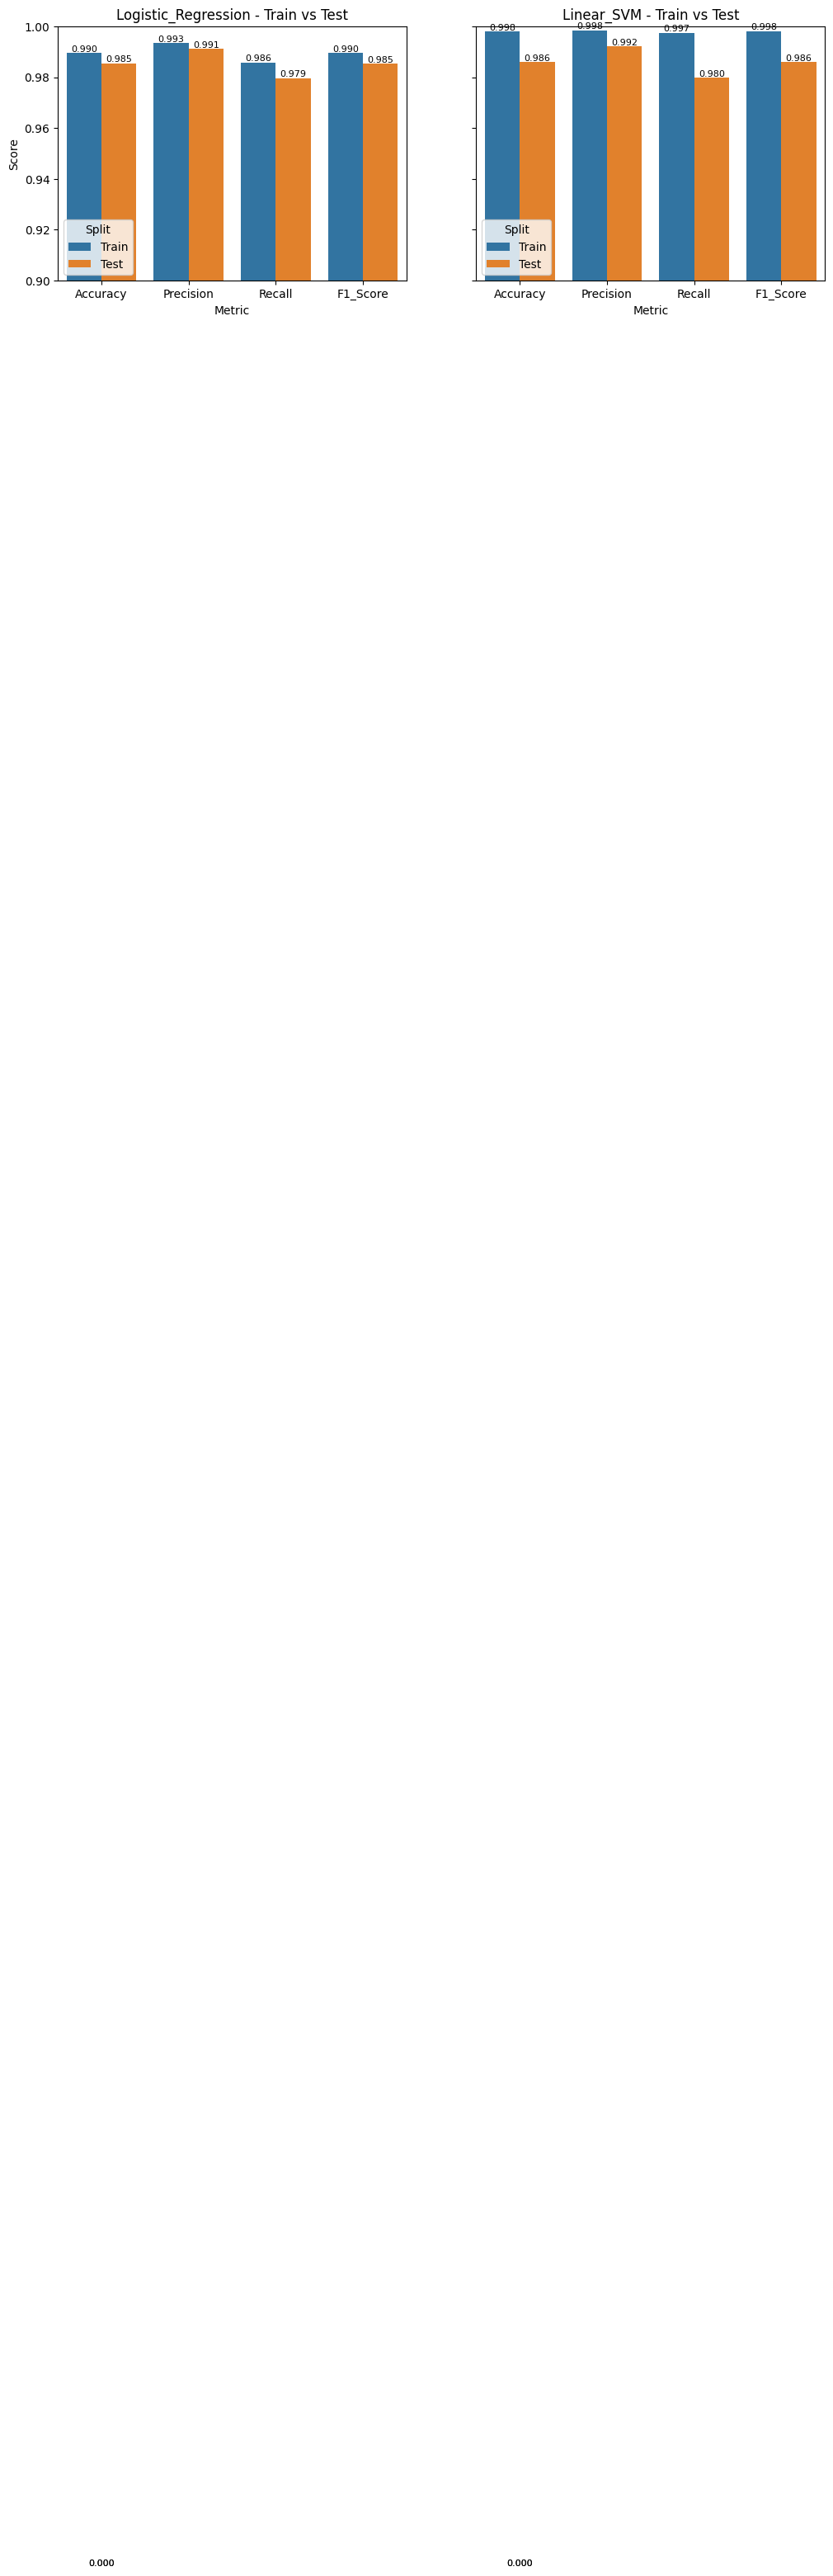

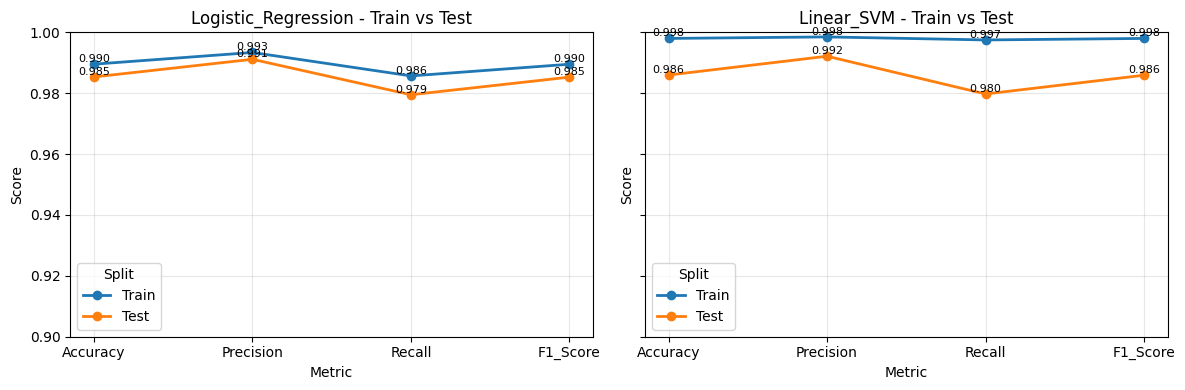

C:\Users\swaga\AppData\Local\Temp\ipykernel_15892\3289094059.py:112: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


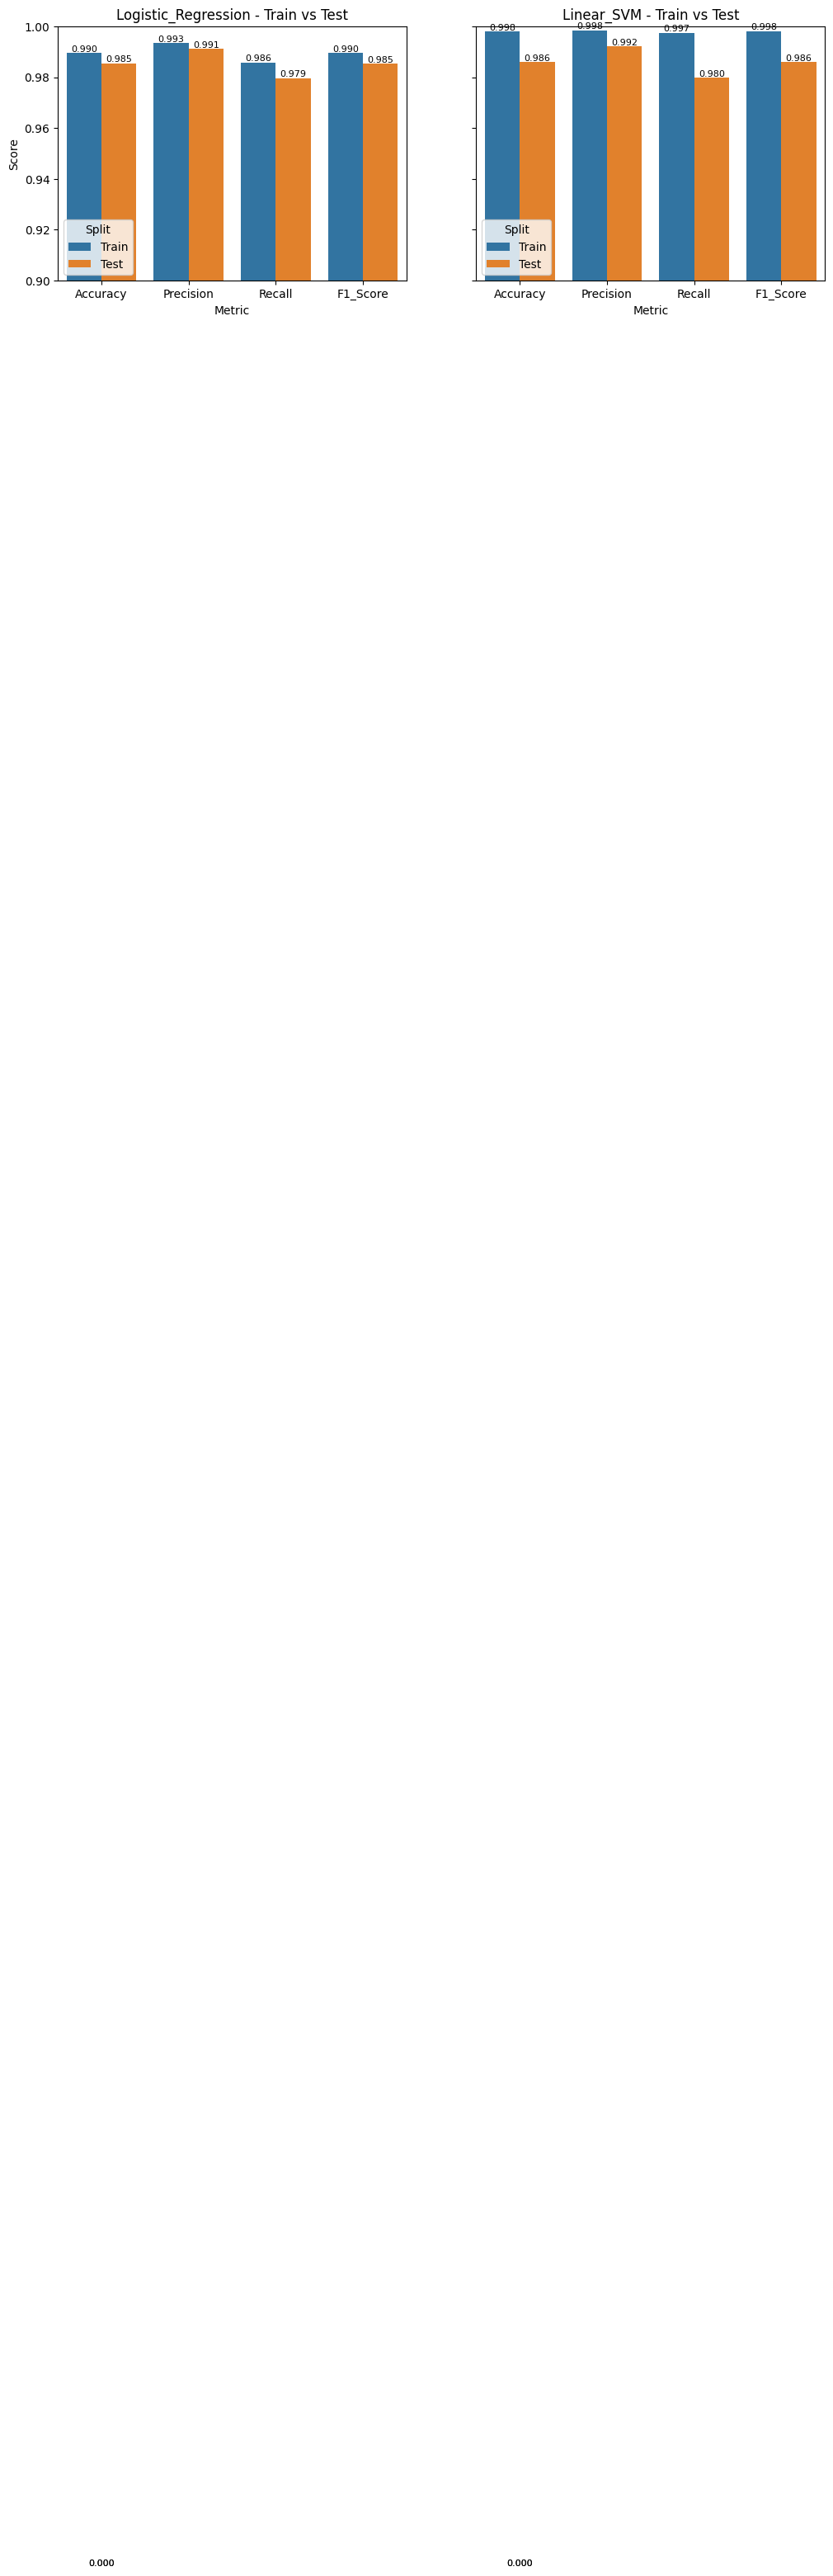

In [9]:
# Load training data
X_train = load_npz("../Models/Features/X_train_tfidf.npz")
y_train = np.load("../Models/Features/y_train.npy")

# Compute training metrics for both models
y_pred_train_lr = lr_model.predict(X_train)
y_pred_train_svm = svm_model.predict(X_train)

train_metrics = {
    "Logistic_Regression": {
        "accuracy": accuracy_score(y_train, y_pred_train_lr),
        "precision": precision_score(y_train, y_pred_train_lr),
        "recall": recall_score(y_train, y_pred_train_lr),
        "f1_score": f1_score(y_train, y_pred_train_lr),
    },
    "Linear_SVM": {
        "accuracy": accuracy_score(y_train, y_pred_train_svm),
        "precision": precision_score(y_train, y_pred_train_svm),
        "recall": recall_score(y_train, y_pred_train_svm),
        "f1_score": f1_score(y_train, y_pred_train_svm),
    },
}

# Use existing test metrics if available; otherwise, compute them
if 'metrics_lr' in globals() and 'metrics_svm' in globals():
    test_metrics = {
        "Logistic_Regression": metrics_lr,
        "Linear_SVM": metrics_svm,
    }
else:
    test_metrics = {
        "Logistic_Regression": evaluate_and_save(lr_model, "Logistic_Regression"),
        "Linear_SVM": evaluate_and_save(svm_model, "Linear_SVM"),
    }

# Simple overfitting check (using F1 gap)
threshold = 0.03  # adjust as needed
for model_name in ["Logistic_Regression", "Linear_SVM"]:
    train_f1 = train_metrics[model_name]["f1_score"]
    test_f1 = test_metrics[model_name]["f1_score"]
    gap = train_f1 - test_f1
    status = "Overfitting" if gap > threshold else "No clear overfitting"
    print(f"{model_name}: Train F1={train_f1:.3f}, Test F1={test_f1:.3f}, Gap={gap:.3f} -> {status}")

# Build dataframe for plotting
metric_names = ["accuracy", "precision", "recall", "f1_score"]
plot_rows = []
for model_name in ["Logistic_Regression", "Linear_SVM"]:
    for m in metric_names:
        plot_rows.append({"model": model_name, "split": "Train", "metric": m.title(), "value": train_metrics[model_name][m]})
        plot_rows.append({"model": model_name, "split": "Test", "metric": m.title(), "value": test_metrics[model_name][m]})
plot_df = pd.DataFrame(plot_rows)

# Ensure output directory exists
os.makedirs("../Models/Evaluation/plots", exist_ok=True)

# Plot grouped bars per metric for each model
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, model_name in zip(axes, ["Logistic_Regression", "Linear_SVM"]):
    data = plot_df[plot_df["model"] == model_name]
    sns.barplot(data=data, x="metric", y="value", hue="split", ax=ax)
    ax.set_title(f"{model_name} - Train vs Test")
    ax.set_ylim(0.90, 1.0)  # zoom in
    ax.set_ylabel("Score")
    ax.set_xlabel("Metric")
    # Add value labels
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height, f"{height:.3f}", ha="center", va="bottom", fontsize=8)
    ax.legend(title="Split")

plt.tight_layout()
plt.savefig("../Models/Evaluation/plots/overfitting_comparison.png", dpi=300)
plt.show()

# Plot line graph for Train vs Test comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, model_name in zip(axes, ["Logistic_Regression", "Linear_SVM"]):
    data = plot_df[plot_df["model"] == model_name]
    for split in ["Train", "Test"]:
        split_data = data[data["split"] == split]
        ax.plot(split_data["metric"], split_data["value"], marker='o', label=split, linewidth=2)
    ax.set_title(f"{model_name} - Train vs Test")
    ax.set_ylim(0.90, 1.0)
    ax.set_ylabel("Score")
    ax.set_xlabel("Metric")
    ax.legend(title="Split")
    ax.grid(True, alpha=0.3)
    # Add value labels
    for split in ["Train", "Test"]:
        split_data = data[data["split"] == split]
        for x, y in zip(range(len(split_data)), split_data["value"]):
            ax.text(x, y, f"{y:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("../Models/Evaluation/plots/overfitting_comparison_line.png", dpi=300)
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, model_name in zip(axes, ["Logistic_Regression", "Linear_SVM"]):
    data = plot_df[plot_df["model"] == model_name]
    sns.barplot(data=data, x="metric", y="value", hue="split", ax=ax)
    ax.set_title(f"{model_name} - Train vs Test")
    ax.set_ylim(0.90, 1.0)  # zoom in
    ax.set_ylabel("Score")
    ax.set_xlabel("Metric")
    # Add value labels
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height, f"{height:.3f}", ha="center", va="bottom", fontsize=8)
    ax.legend(title="Split")

plt.tight_layout()
plt.savefig("../Models/Evaluation/plots/overfitting_comparison.png", dpi=300)
plt.show()